# LSST CCOB ghost study distance

Explore the properties of the reduced distance I have defined

## TODO
- ?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1
from ghosts.geom_config import GEOM_CONFIG_0


In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0

Direct path is number 28
  central impact point is (0.099514, 0.000025)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 675.3467


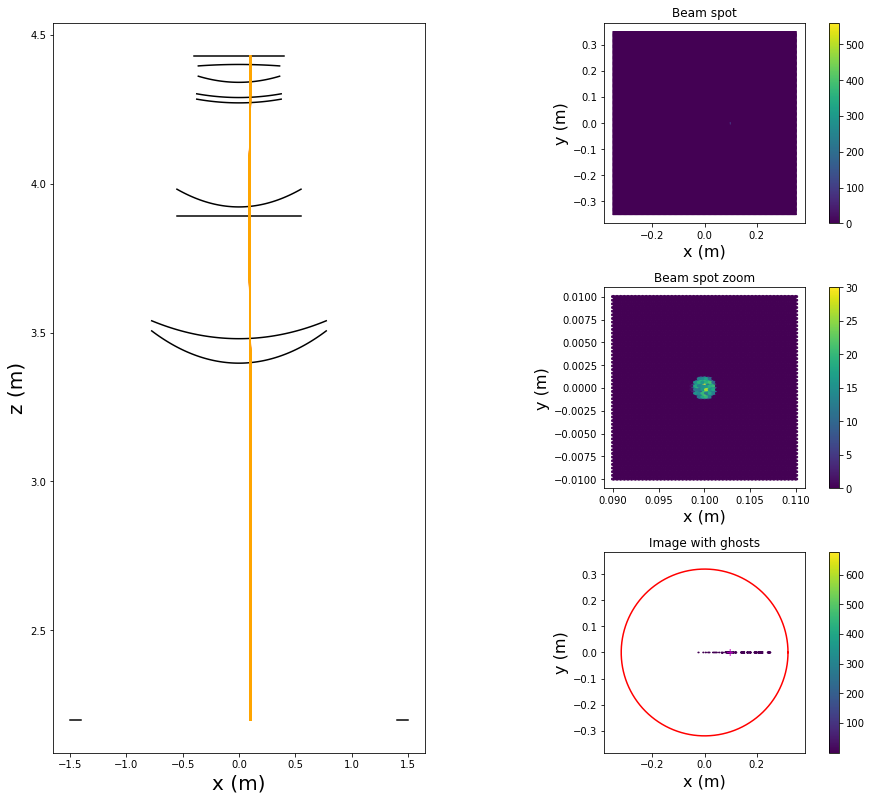

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


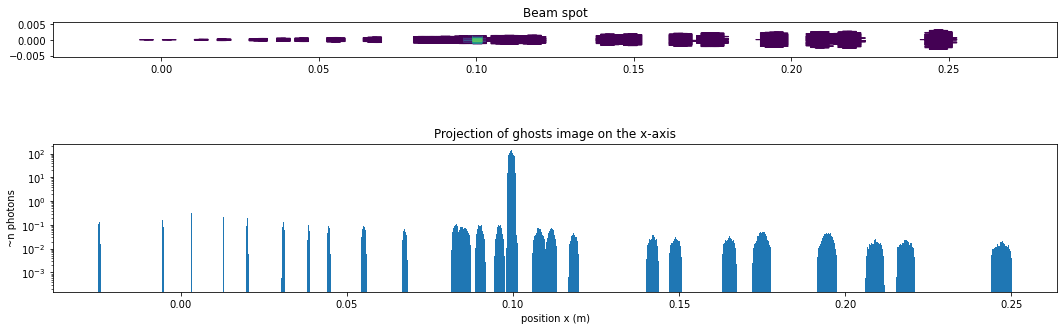

0

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


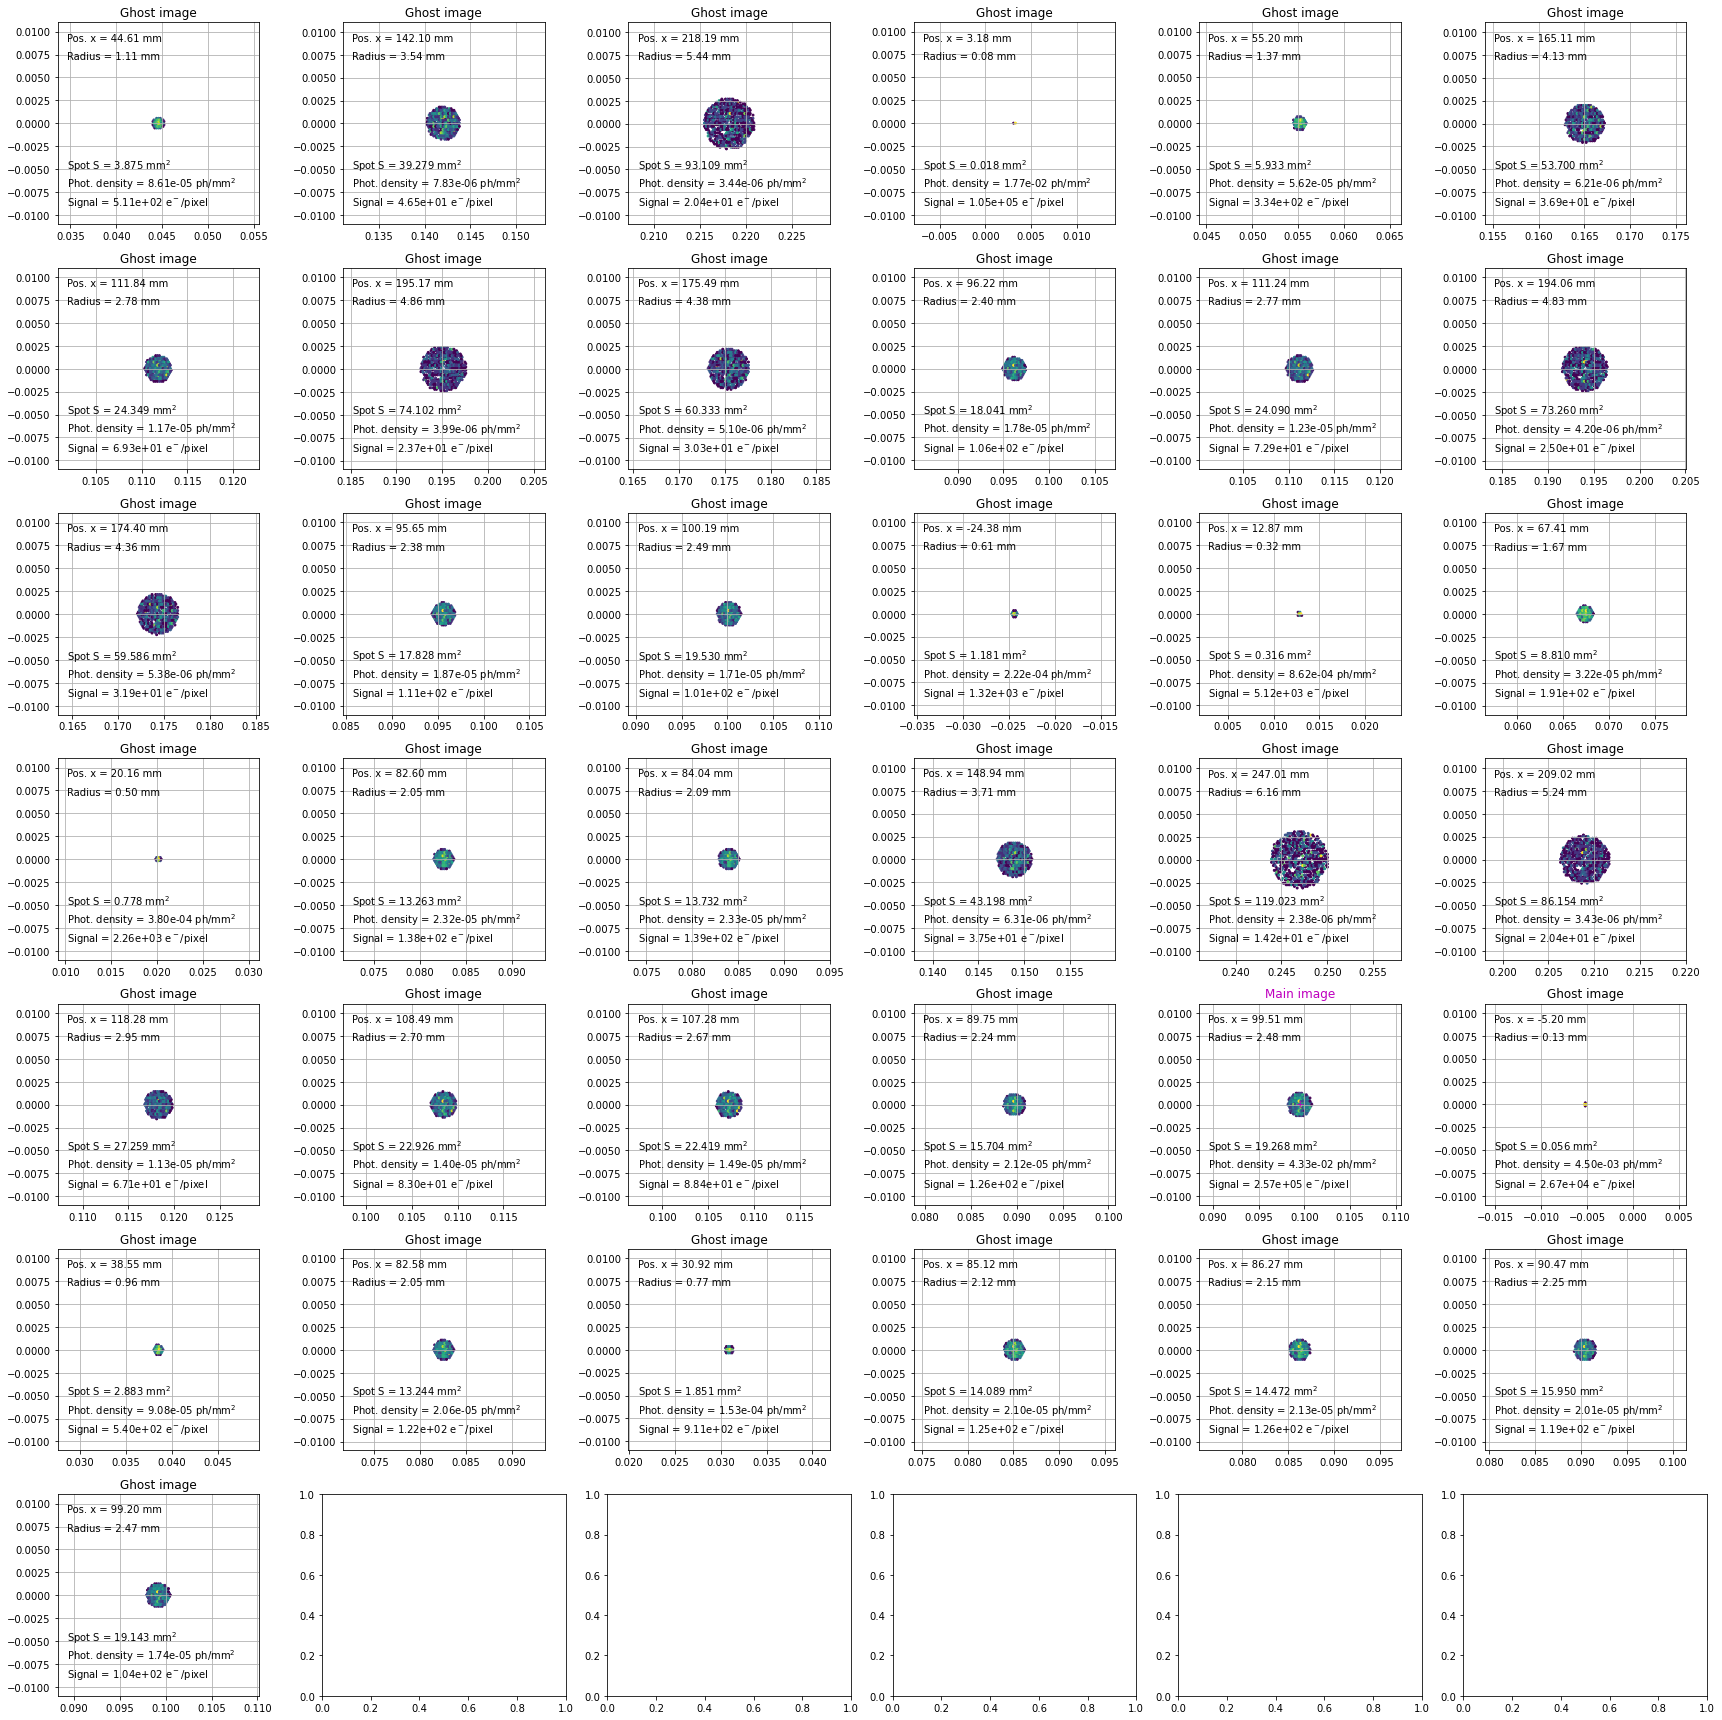

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1['beam_id'], GEOM_CONFIG_0['geom_id'])
data_frame_1.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
33,1,0,33,"(Detector, Filter_entrance)",0.085124,0.000516,2.148203e-05,0.000516,0.002121,0.002115,0.002118,3.129485e-06,0.295428,14.089246,124.615787
34,1,0,34,"(Detector, Filter_exit)",0.086272,0.000523,2.177175e-05,0.000523,0.002150,0.002143,0.002146,3.212202e-06,0.307609,14.472393,126.318895
29,1,0,29,"(Detector, L1_entrance)",-0.005199,0.000033,-1.311581e-06,0.000033,0.000138,0.000129,0.000133,4.267779e-06,0.251339,0.055912,26715.804556
30,1,0,30,"(Detector, L1_exit)",0.038551,0.000233,9.729006e-06,0.000233,0.000958,0.000958,0.000958,2.115063e-07,0.261702,2.882523,539.565924
31,1,0,31,"(Detector, L2_entrance)",0.082581,0.000500,2.084047e-05,0.000500,0.002055,0.002051,0.002053,1.787904e-06,0.272493,13.244036,122.277000
32,1,0,32,"(Detector, L2_exit)",0.030917,0.000187,7.802355e-06,0.000187,0.000767,0.000768,0.000768,4.544470e-07,0.283729,1.850869,911.039658
35,1,0,35,"(Detector, L3_entrance)",0.090475,0.000550,2.283208e-05,0.000550,0.002259,0.002248,0.002253,5.719572e-06,0.320293,15.949920,119.343295
36,1,0,36,"(Detector, L3_exit)",0.099196,0.000602,2.503329e-05,0.000602,0.002473,0.002464,0.002468,4.300109e-06,0.333499,19.142773,103.537942
10,1,0,10,"(Filter_entrance, L1_entrance)",0.111240,0.000675,2.807249e-05,0.000675,0.002775,0.002763,0.002769,5.780022e-06,0.295428,24.089831,72.883139
11,1,0,11,"(Filter_entrance, L1_exit)",0.194061,0.001177,4.897346e-05,0.001177,0.004837,0.004821,0.004829,8.281210e-06,0.307609,73.259970,24.954101


In [10]:
# start to study how the reduced distance evolves when scanning one parameter
angles = [i*0.01 for i in range(-10, 11)]
angles_list, distances_2d, distances_3d = \
    simulator.scan_dist_rotation(telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                                 angles_list=angles, r_scale=10)

-0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from -0.100 to 0.100 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

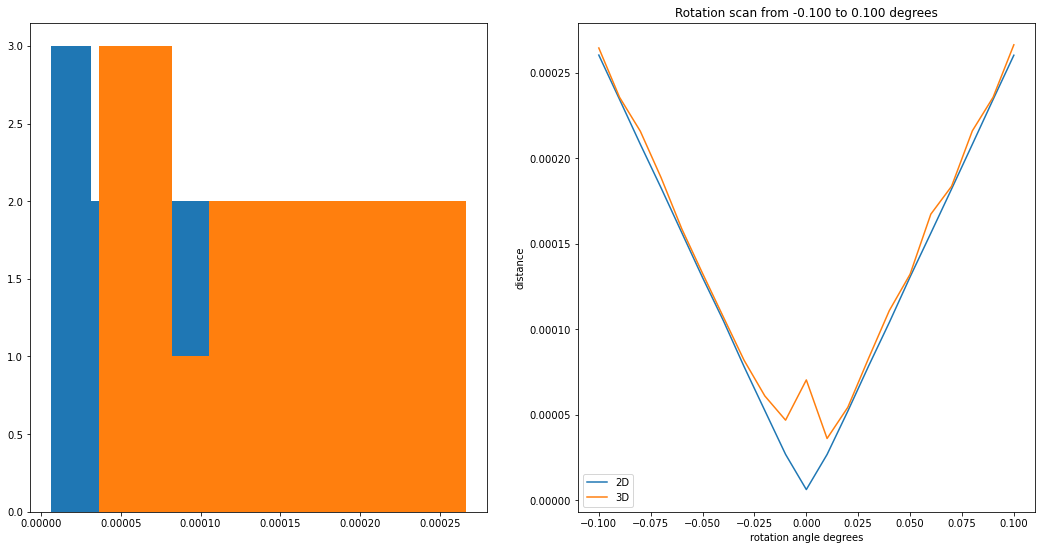

In [11]:
plotter.plot_distances_for_scan(angles_list, distances_2d, distances_3d)

In [12]:
angles_list, distances_2d_y, distances_3d_y = \
    simulator.scan_dist_rotation(telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='y',
                       angles_list=angles, r_scale=10)

-0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from -0.100 to 0.100 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

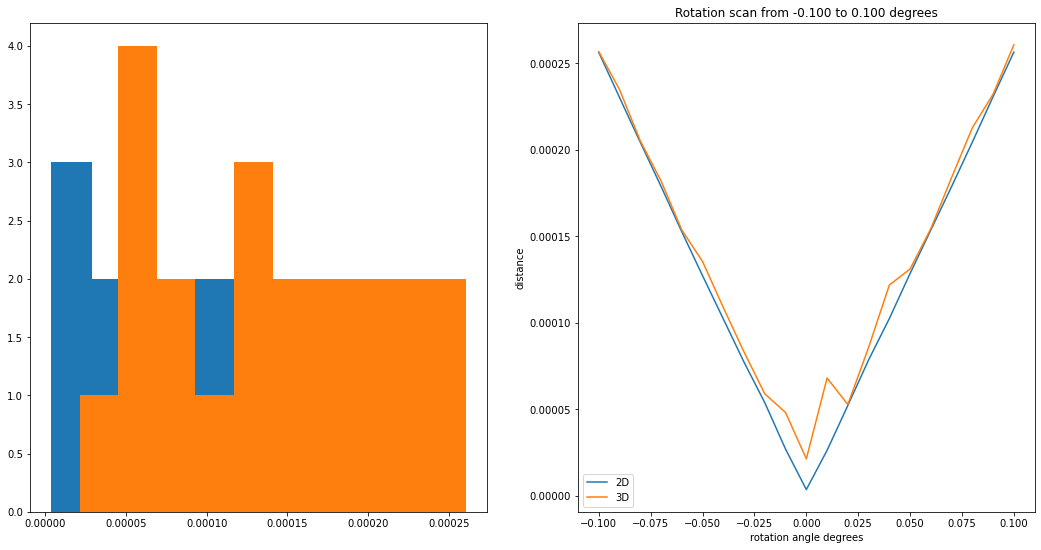

In [13]:
plotter.plot_distances_for_scan(angles_list, distances_2d_y, distances_3d_y)

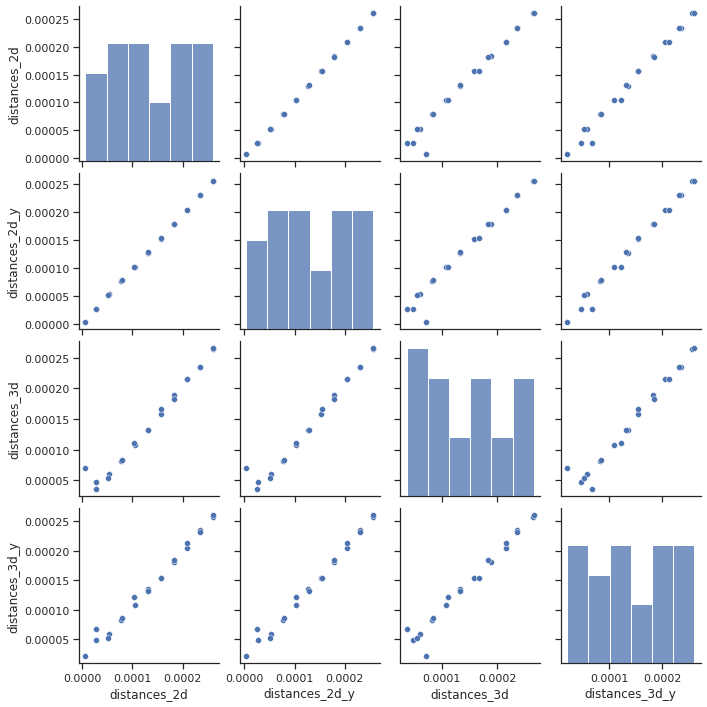

In [14]:
# correlations between distances
plt.rcParams["figure.figsize"] = [24, 24]
pd_distances = pd.DataFrame(
    {
        "distances_2d": np.array(distances_2d, dtype="float"),
        "distances_2d_y": np.array(distances_2d_y, dtype="float"),
        "distances_3d": np.array(distances_3d, dtype="float"),
        "distances_3d_y": np.array(distances_3d_y, dtype="float"),
    }
)

import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(pd_distances)

In [15]:
# use a tweaked telescope as a basis before the scan
new_geom_config=copy.deepcopy(GEOM_CONFIG_0)
new_geom_config['L1_rx'] = 0.1
tweaked_telescope = tweak_optics.tweak_telescope(telescope, new_geom_config)
tweak_optics.make_optics_reflective(tweaked_telescope)


0

In [16]:
angles_s = [i*0.01 for i in range(-10, 21)]
angles_list_s, distances_2d_L1rot, distances_3d_L1rot = \
    simulator.scan_dist_rotation(tweaked_telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                       angles_list=angles_s, r_scale=10)

-0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from -0.100 to 0.200 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

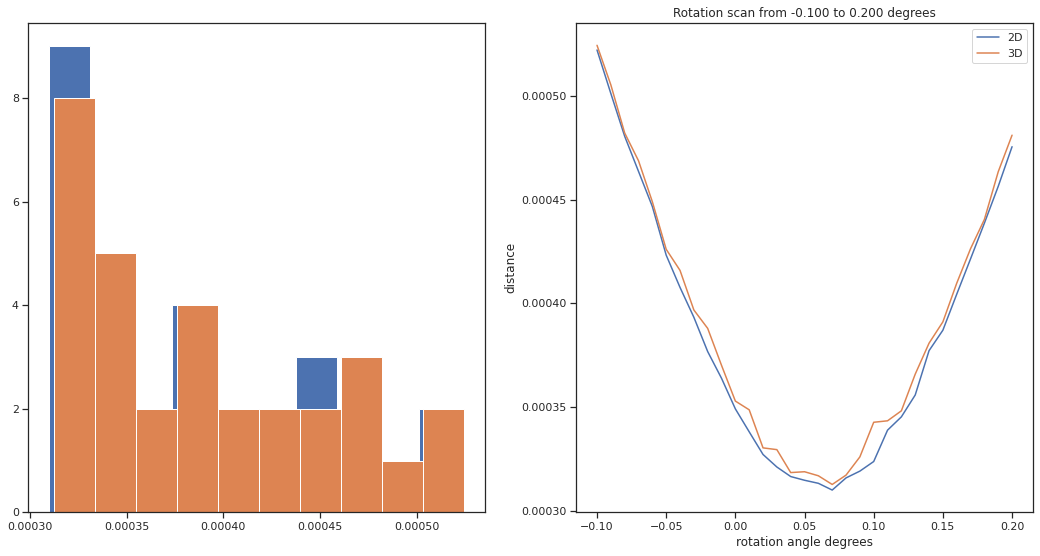

In [17]:
plotter.plot_distances_for_scan(angles_list_s, distances_2d_L1rot, distances_3d_L1rot)

In [18]:
# study scale factor
angles_20 = [i*0.01 for i in range(-10, 21)]
dist_2d_list = list()
dist_3d_list = list()
for scale in [1, 5, 10, 30, 50]:
    angles_list_20, d2d, d3d = \
        simulator.scan_dist_rotation(tweaked_telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                       angles_list=angles_20, r_scale=scale)
    dist_2d_list.append(d2d)
    dist_3d_list.append(d3d)

-0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 -0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 -0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 -0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 -0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 

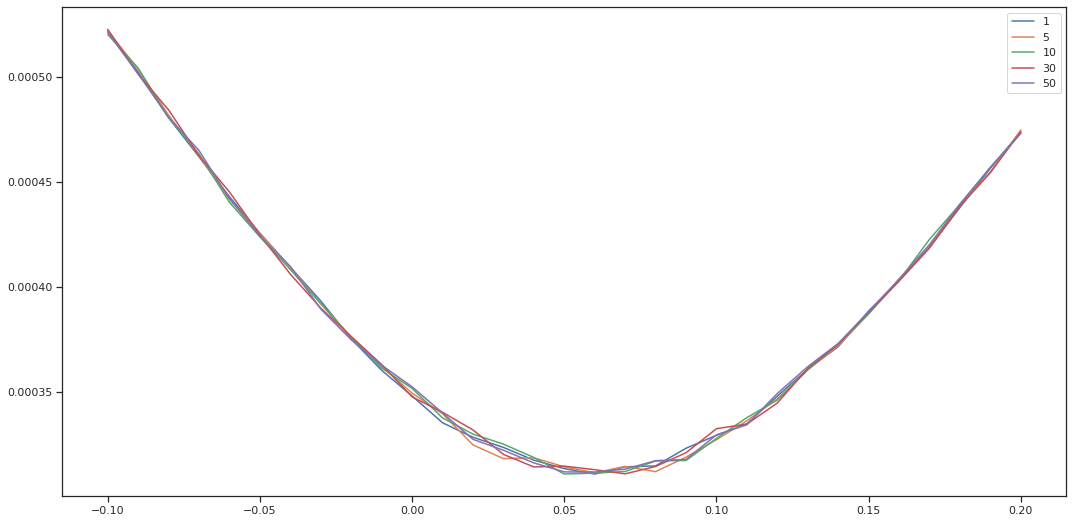

In [19]:
# 2D - no effect
scales = [1, 5, 10, 30, 50]
for i, d in enumerate(dist_2d_list):
    plt.plot(angles_20, d, label=scales[i])
plt.legend()

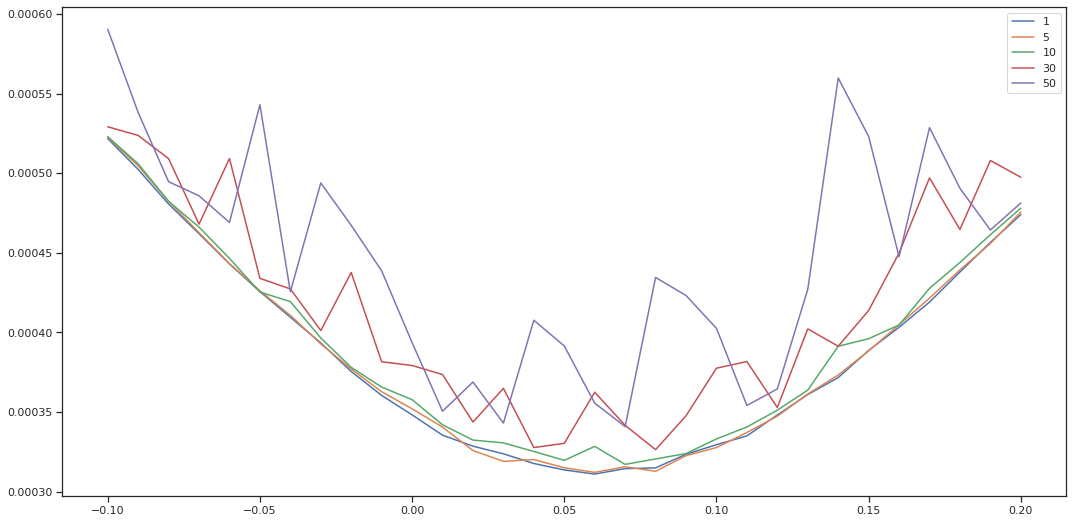

In [20]:
# 3D
scales = [1, 5, 10, 30, 50]
for i, d in enumerate(dist_3d_list):
    plt.plot(angles_20, d, label=scales[i])
plt.legend()

In [21]:
# let's tweak again
#tw2 = {'L1':{'shift':[0.001, -0.1, 0.]},
#       'L2':{'shift':[0.0,0.001,0.], 'rotations':[0.0, -0.05, 0.]},
#       'L3':{'shift':[0.0,0.001,0.], 'rotations':[0.05, -0.05, 0.]}}
# use a tweaked telescope as a basis before the scan
new_geom_config_2=copy.deepcopy(GEOM_CONFIG_0)
new_geom_config_2['L1_dx'] = 0.001
new_geom_config_2['L1_dy'] = -0.1
new_geom_config_2['L2_dy'] = 0.001
new_geom_config_2['L2_ry'] = -0.05
new_geom_config_2['L3_dy'] = 0.001
new_geom_config_2['L3_rx'] = 0.05
new_geom_config_2['L3_ry'] = -0.05

very_tweaked_telescope = tweak_optics.tweak_telescope(telescope, new_geom_config_2)
tweak_optics.make_optics_reflective(very_tweaked_telescope)


0

In [22]:
angles_s2 = np.arange(-2, -0.5, 0.1)
angles_list_s2, distances_2d_tw, distances_3d_tw = \
    simulator.scan_dist_rotation(very_tweaked_telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                       angles_list=angles_s2, r_scale=10)

-2.0 -1.9 -1.7999999999999998 -1.6999999999999997 -1.5999999999999996 -1.4999999999999996 -1.3999999999999995 -1.2999999999999994 -1.1999999999999993 -1.0999999999999992 -0.9999999999999991 -0.899999999999999 -0.7999999999999989 -0.6999999999999988 -0.5999999999999988 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from -2.000 to -0.600 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

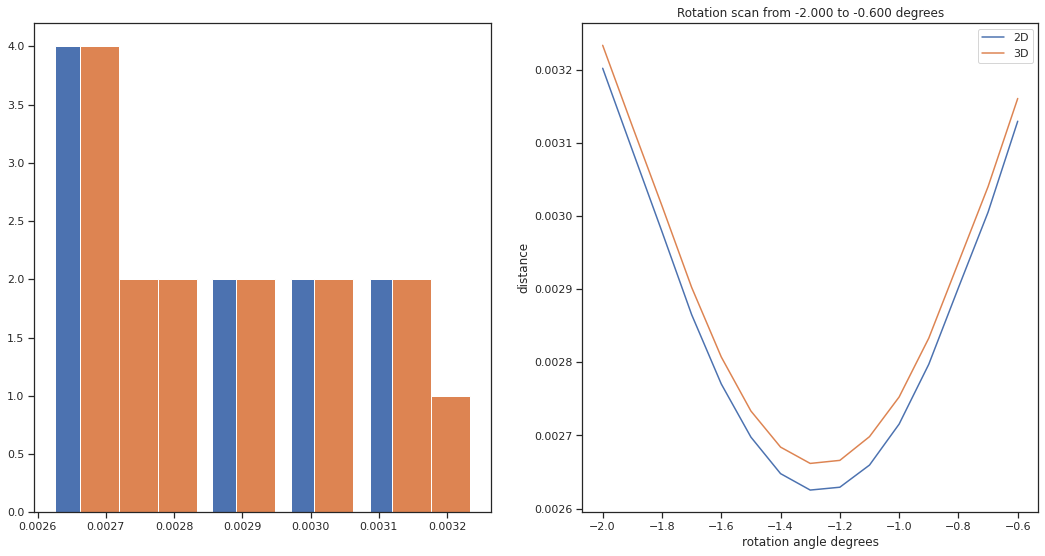

In [23]:
plotter.plot_distances_for_scan(angles_list_s2, distances_2d_tw, distances_3d_tw)

In [24]:
# fine scan with super tweaked telescope
angles_fine = np.arange(-1.5, -1.0, 0.01)
angles_list_fine, distances_2d_tw_fine, distances_3d_tw_fine = \
    simulator.scan_dist_rotation(very_tweaked_telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                       angles_list=angles_fine, r_scale=10)

-1.5 -1.49 -1.48 -1.47 -1.46 -1.45 -1.44 -1.43 -1.42 -1.41 -1.4 -1.39 -1.38 -1.3699999999999999 -1.3599999999999999 -1.3499999999999999 -1.3399999999999999 -1.3299999999999998 -1.3199999999999998 -1.3099999999999998 -1.2999999999999998 -1.2899999999999998 -1.2799999999999998 -1.2699999999999998 -1.2599999999999998 -1.2499999999999998 -1.2399999999999998 -1.2299999999999998 -1.2199999999999998 -1.2099999999999997 -1.1999999999999997 -1.1899999999999997 -1.1799999999999997 -1.1699999999999997 -1.1599999999999997 -1.1499999999999997 -1.1399999999999997 -1.1299999999999997 -1.1199999999999997 -1.1099999999999997 -1.0999999999999996 -1.0899999999999996 -1.0799999999999996 -1.0699999999999996 -1.0599999999999996 -1.0499999999999996 -1.0399999999999996 -1.0299999999999996 -1.0199999999999996 -1.0099999999999996 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from -1.500 to -1.010 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

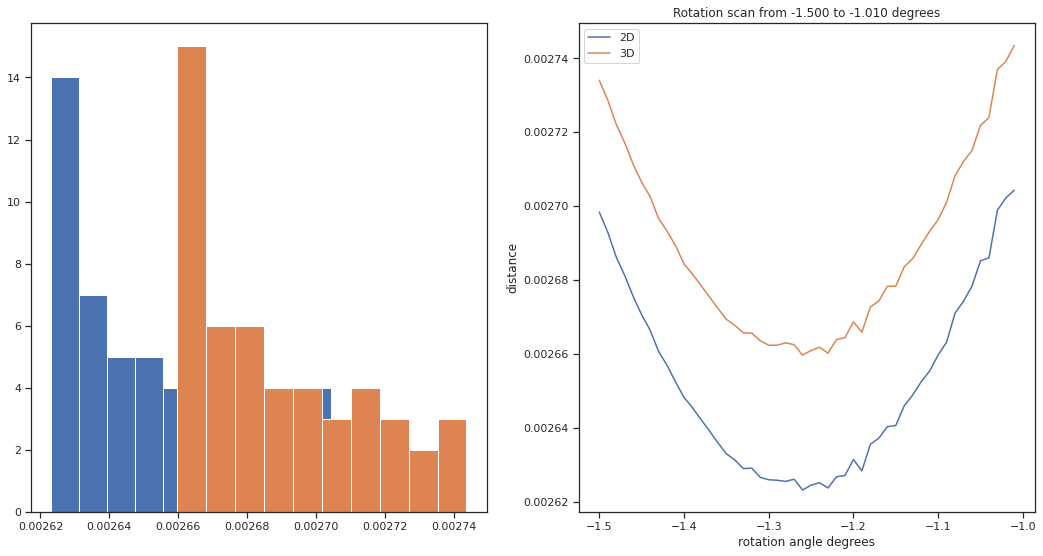

In [25]:
plotter.plot_distances_for_scan(angles_fine, distances_2d_tw_fine, distances_3d_tw_fine)

In [26]:
# now trying a translation scan with the default telescope
# 100 mu steps
dx_scan = [i*0.0001 for i in range(-10, 10)]
shifts_list, distances_2d_trans, distances_3d_trans = \
    simulator.scan_dist_translation(telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                       shifts_list=dx_scan, r_scale=10)

-0.001000 -0.000900 -0.000800 -0.000700 -0.000600 -0.000500 -0.000400 -0.000300 -0.000200 -0.000100 0.000000 0.000100 0.000200 0.000300 0.000400 0.000500 0.000600 0.000700 0.000800 0.000900 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Translation scan from -0.00100 to 0.00090 m'}, xlabel='shift in meters', ylabel='distance'>],
       dtype=object))

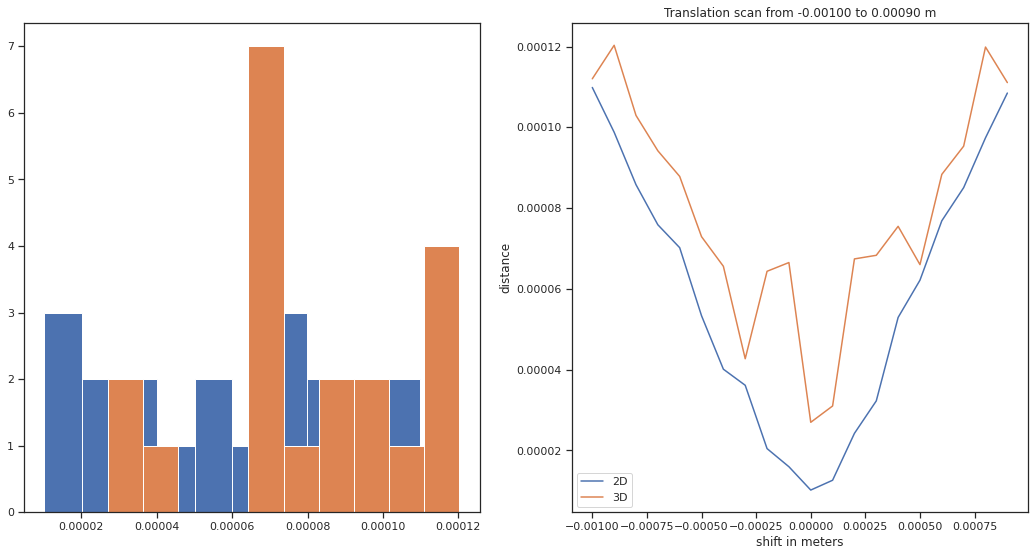

In [27]:
plotter.plot_distances_for_scan(shifts_list, distances_2d_trans, distances_3d_trans, scan_type='translation')

In [28]:
# now trying a translation scan with the default telescope
# 10 mu steps
dx_scan = [i*0.00001 for i in range(-40, 40)]
shifts_list_10mu, distances_2d_trans_10mu, distances_3d_trans_10mu = \
    simulator.scan_dist_translation(telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                       shifts_list=dx_scan, r_scale=10)

-0.000400 -0.000390 -0.000380 -0.000370 -0.000360 -0.000350 -0.000340 -0.000330 -0.000320 -0.000310 -0.000300 -0.000290 -0.000280 -0.000270 -0.000260 -0.000250 -0.000240 -0.000230 -0.000220 -0.000210 -0.000200 -0.000190 -0.000180 -0.000170 -0.000160 -0.000150 -0.000140 -0.000130 -0.000120 -0.000110 -0.000100 -0.000090 -0.000080 -0.000070 -0.000060 -0.000050 -0.000040 -0.000030 -0.000020 -0.000010 0.000000 0.000010 0.000020 0.000030 0.000040 0.000050 0.000060 0.000070 0.000080 0.000090 0.000100 0.000110 0.000120 0.000130 0.000140 0.000150 0.000160 0.000170 0.000180 0.000190 0.000200 0.000210 0.000220 0.000230 0.000240 0.000250 0.000260 0.000270 0.000280 0.000290 0.000300 0.000310 0.000320 0.000330 0.000340 0.000350 0.000360 0.000370 0.000380 0.000390 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Translation scan from -0.00040 to 0.00039 m'}, xlabel='shift in meters', ylabel='distance'>],
       dtype=object))

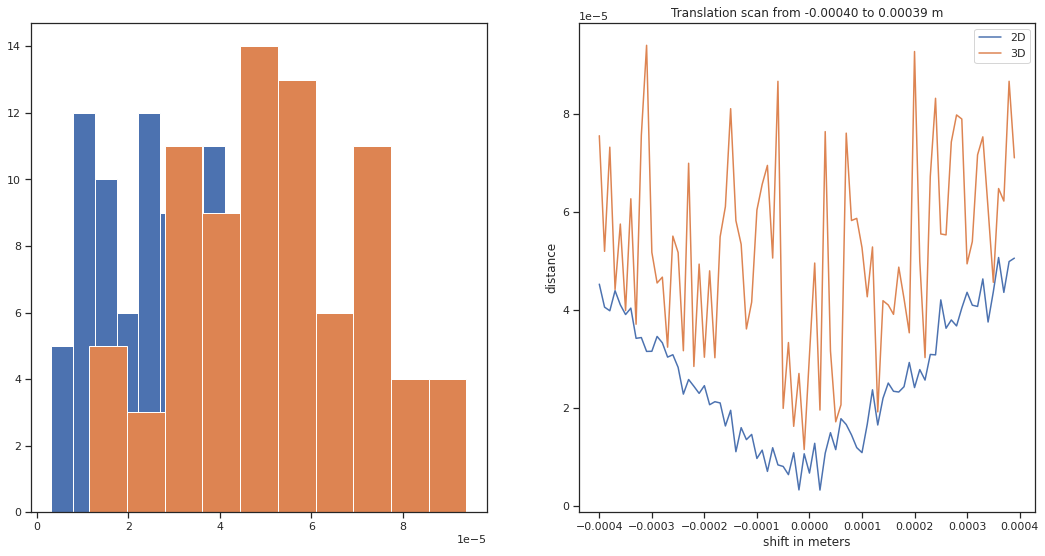

In [29]:
plotter.plot_distances_for_scan(shifts_list_10mu, distances_2d_trans_10mu, distances_3d_trans_10mu, scan_type='translation')

In [30]:
# now trying a translation scan with the tweaked telescope
# 100 mu steps, large range
dx_scan = np.arange(-0.050, 0., 0.0001)
shifts_list_10mu_tw, distances_2d_trans_10mu_tw, distances_3d_trans_10mu_tw = \
    simulator.scan_dist_translation(very_tweaked_telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x',
                       shifts_list=dx_scan, r_scale=10)

-0.050000 -0.049900 -0.049800 -0.049700 -0.049600 -0.049500 -0.049400 -0.049300 -0.049200 -0.049100 -0.049000 -0.048900 -0.048800 -0.048700 -0.048600 -0.048500 -0.048400 -0.048300 -0.048200 -0.048100 -0.048000 -0.047900 -0.047800 -0.047700 -0.047600 -0.047500 -0.047400 -0.047300 -0.047200 -0.047100 -0.047000 -0.046900 -0.046800 -0.046700 -0.046600 -0.046500 -0.046400 -0.046300 -0.046200 -0.046100 -0.046000 -0.045900 -0.045800 -0.045700 -0.045600 -0.045500 -0.045400 -0.045300 -0.045200 -0.045100 -0.045000 -0.044900 -0.044800 -0.044700 -0.044600 -0.044500 -0.044400 -0.044300 -0.044200 -0.044100 -0.044000 -0.043900 -0.043800 -0.043700 -0.043600 -0.043500 -0.043400 -0.043300 -0.043200 -0.043100 -0.043000 -0.042900 -0.042800 -0.042700 -0.042600 -0.042500 -0.042400 -0.042300 -0.042200 -0.042100 -0.042000 -0.041900 -0.041800 -0.041700 -0.041600 -0.041500 -0.041400 -0.041300 -0.041200 -0.041100 -0.041000 -0.040900 -0.040800 -0.040700 -0.040600 -0.040500 -0.040400 -0.040300 -0.040200 -0.040100 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Translation scan from -0.05000 to -0.00010 m'}, xlabel='shift in meters', ylabel='distance'>],
       dtype=object))

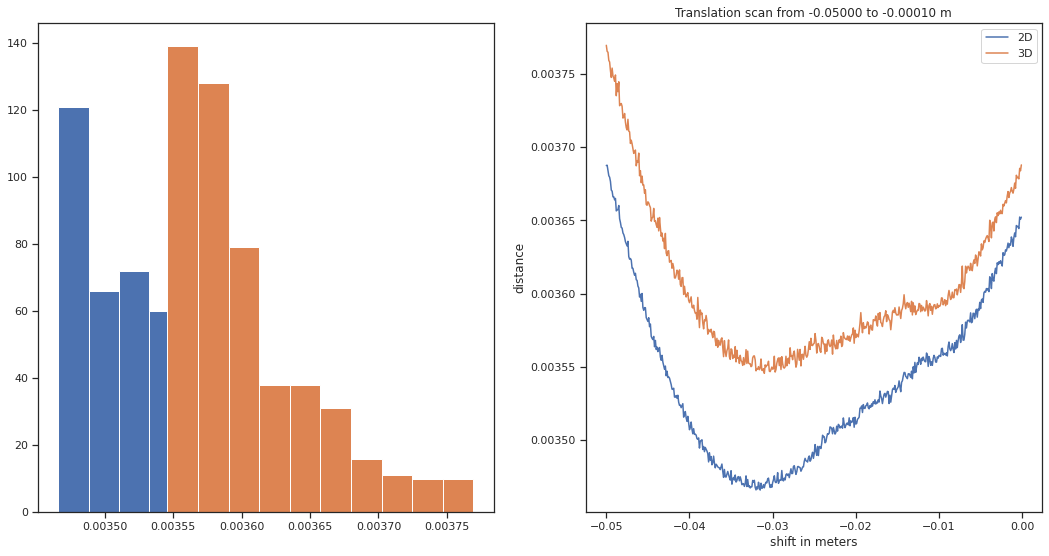

In [31]:
plotter.plot_distances_for_scan(shifts_list_10mu_tw, distances_2d_trans_10mu_tw, distances_3d_trans_10mu_tw, scan_type='translation')